# Deep learning the slow modes for rare events sampling

**A tutorial on Deep-TICA CVs training** 

Luigi Bonati, 2021

---
This is a brief tutorial that describes how to train the Deep-TICA CVs from a biased simulation.
We use a OPES-multithermal simulation of alanine dipeptide as example, using all distances between heavy atoms as input descriptors.

**Reference**: 

Bonati, Piccini, and Parrinello. ["Deep learning the slow modes for rare events sampling"](https://arxiv.org/abs/2107.03943). _arXiv preprint_ arXiv:2107.03943 (2021).

---

**Outline**:

1.  Load data
2.  Preprocessing (rescale time)
3.  Create training set
4.  Train
5.  Analysis
6.  Export

## Import 

**Requirements**: 
* numpy
* pandas
* torch
* matplotlib
* **mlcvs** (contained in this repository)

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys

#add mlcvs to system path TODO
sys.path.append('../')
import mlcvs
from mlcvs.io import load_colvar
from mlcvs.tica import DeepTICA,create_tica_dataset
from mlcvs.palette import cm_fessa
from mlcvs.fes import compute_fes_1d, compute_fes_2d

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data

We use the function `load_colvar` from `mlcvs.utils` that takes a PLUMED COLVAR file and returns a pandas dataframe. First we load the COLVAR file containing the data about the OPES-multicanonical simulation and then the COLVAR_DRIVER which contains the input descriptors calculated along the trajectories (the second step can be avoided if they are already present in the first file).

We also discard the initial part of the simulation to put ourselves in the quasi-static regime, which is very quickly reached by OPES (it can be monitored by looking at the DELTAFS file for the multicanonical simulation).

---

| Parameter | Type | Description |
| :- | :- | :- |
| folder | str |files location |
| from_time | float | discard initial part of the trajectories [time units] |
| descriptor_filter | str |filter descriptors based on names |

In [2]:
#------------- PARAMETERS -------------
folder            = 'test-ala2-multi/'
from_time         = 15000.
descriptor_filter = 'd'
#--------------------------------------

# Load files
colvar = load_colvar(folder=folder,filename='COLVAR')
descr = load_colvar(folder=folder,filename='COLVAR_DRIVER')

# Concatenate without duplicates
colvar = pd.concat([colvar, descr[[i for i in descr.columns if (i not in colvar.columns)]]], axis=1)

# Discard initial part of trajectory

colvar = colvar[ colvar['time']>from_time ]

# Descriptors 
X = colvar.filter(regex=descriptor_filter).values
n_input = X.shape[1]

colvar

,time,phi,psi,ene,opes.bias,d1,d2,d3,d4,d5,...,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
15001,15001.0,-1.50515,1.438650,43.3469,-30.144900,0.1522,0.235165,0.241863,0.375188,0.489479,...,0.255153,0.295903,0.367831,0.502540,0.1229,0.1335,0.252509,0.223947,0.291499,0.1449
15002,15002.0,-1.29419,1.730900,-18.3581,-0.562392,0.1522,0.244679,0.231301,0.370506,0.454905,...,0.252451,0.285218,0.363133,0.486784,0.1229,0.1335,0.241549,0.226609,0.276819,0.1449
15003,15003.0,-2.53166,2.657820,-23.8477,0.715870,0.1522,0.234523,0.246725,0.382103,0.441149,...,0.250699,0.317424,0.312897,0.441096,0.1229,0.1335,0.246988,0.230302,0.292824,0.1449
15004,15004.0,-2.15710,2.395360,11.5125,-14.231600,0.1522,0.234793,0.251158,0.383453,0.475197,...,0.262807,0.326766,0.339187,0.479339,0.1229,0.1335,0.251390,0.224343,0.292820,0.1449
15005,15005.0,-2.64771,2.908030,-31.7069,1.482910,0.1522,0.243266,0.237491,0.377612,0.455769,...,0.254699,0.341980,0.308678,0.445237,0.1229,0.1335,0.249406,0.228642,0.294013,0.1449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996.0,-1.31044,-0.023952,-33.1943,1.544550,0.1522,0.237438,0.245095,0.377144,0.479982,...,0.246469,0.276428,0.354929,0.473255,0.1229,0.1335,0.249179,0.221805,0.281781,0.1449
49997,49997.0,-1.66419,2.736990,-32.5060,1.518380,0.1522,0.240949,0.244720,0.385074,0.481208,...,0.253170,0.327638,0.315540,0.453209,0.1229,0.1335,0.240503,0.223382,0.272337,0.1449
49998,49998.0,-1.71317,2.573260,19.0074,-17.968700,0.1522,0.240229,0.247424,0.383137,0.488402,...,0.245395,0.310855,0.318514,0.438564,0.1229,0.1335,0.243461,0.226024,0.279091,0.1449
49999,49999.0,-1.26937,2.127590,7.2590,-12.103300,0.1522,0.241292,0.235914,0.373783,0.470397,...,0.254010,0.289084,0.355414,0.456283,0.1229,0.1335,0.247204,0.220562,0.278850,0.1449


## 2. Preprocessing (rescale time)

Here we extract the time $t$, the energy $E$ (needed for the multicanonical reweight [1]) and the bias $V$ from the COLVAR file. We then calculate the weights as:

\begin{cases}
    w = e^{\beta\ V + (\beta_0-\beta)\ E} & \text{if multicanonical}\\
    w = e^{\beta\ V}              & \text{otherwise}
\end{cases}

NB: note that if simulation temperature $\beta_0$ is equal to the reweighting one $\beta$ the multicanonical reweight coincides with the standard umbrella sampling-like case.

Once we have computed the weights, we rescale the time at step $k$ by using the instantaneus acceleration:

$$ dt'_k = w_k\ dt $$

and then compute the cumulative rescaled time:

$$ t'_k = \sum_{i=0} ^k dt'_i $$



[1] Invernizzi, Piaggi, and Parrinello. "Unified approach to enhanced sampling." _Physical Review X_ 10.4 (2020): 041034.


---

| Parameter | Type | Description |
| :- | :- | :- |
| multicanonical | bool | flag to determine if using a standard reweight (false) or a multicanonical one (true) |
| temp | float | reweighting temperature |
| temp0 | float | simulation temperature (only needed if multicanonical == True) |




In [3]:
#------------- PARAMETERS -------------
multicanonical    = True
temp              = 300.
temp0             = 300.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = colvar['time'].values # save time
ene = colvar['ene'].values.astype(np.float64) # store energy as long double
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweight += (beta0-beta)*ene

## Time rescaling

# compute time increment in simulation time t
dt = np.round(t[1]-t[0],3)

# compute instantaneus time increment in rescaled time t'
d_tprime = np.copy(np.exp(logweight)*dt)

#calculate cumulative time tau
tprime = np.cumsum(d_tprime)

## 3. Create training set

In order to train the Deep-TICA CVs we will need to compute the time-lagged covariance matrices in the rescaled time $t'$. The standard way is to look for configurations which are distant a lag-time $\tau$ in the time series. However, in the rescaled time the time-series is _exponentially_ unevenly spaced. Hence, a naive search will lead to severe numerical issue. To address this, we use the algorithm proposed in [2]. In a nutshell, this method assume that the observable $O(t'_k)$ have the same value from scaled time $t'_k$ to $t'_{k+1}$. This leads to weighting each pair of configurations based both on the rescaled time around $t'_k$ and $t'_k+\tau$ (see supp. information of [2] for details). All of this is done under the hood by the function `mlcvs.tica.look_for_configurations`. 

To generate the the training and validation set, we use the function `create_tica_dataset` which searches for the pairs of configurations and the corresponding weight, and save them in datasets for training/validation

[2] Yang and Parrinello. "Refining collective coordinates and improving free energy representation in variational enhanced sampling." _Journal of chemical theory and computation_ 14.6 (2018): 2889-2894.

---

| Parameter | Type | Description |
| :- | :- | :- |
| lag_time | float | lag_time for the calculation of the covariance matrices [in rescaled time] |
| n_train | int | number of training configurations |
| n_valid | int | number of validation configurations |
| batch_tr | int | number of configurations per batch (-1 equals single batch) |


In [4]:
#------------- PARAMETERS -------------
lag_time = 1.
n_train  = 25000 
n_valid  = 10000
batch_tr = -1
#--------------------------------------

# Create train and valid dataset
train_data,valid_data = create_tica_dataset(X, 
                                            tprime,
                                            lag_time=lag_time,
                                            n_train=n_train,
                                            n_valid=n_valid,
                                            batch_tr=batch_tr,
                                            every=1)

[SPLIT DATASET]
- Training points = 25000
- Search (x_t,x_t+lag) with lag time = 1.0
Using device: cuda

Quadro RTX 5000 with Max-Q Design


/workspace/deep-learning-slow-modes/tutorial/../mlcvs/tica.py:561: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:229.)
  x_t = torch.Tensor(x_t).to(device)


- Found n_pairs = 49987
- Batch size = 49987
- N batches = 1
Using device: cuda

Quadro RTX 5000 with Max-Q Design


## 4. Train

Here we setup a few parameters and then train the Deep-TICA CVs. We first instantiate a object of the `DeepTICA` class which defines the NN but also the loss function and a train loop. See class documentation for further details about parameters and methods.

---

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of TICA  |
| activ_type | string | Activation function (relu,tanh,elu,linear) |
| loss_type | string | Loss function operating on the TICA eigenvalues (sum2,sum,single)|
| n_eig | int | Number of eigenvalues to optimize (or if loss_type=single which one to select) |
| **Optimization** |
| lrate | float | Learning rate |
| l2_reg | float | L2 regularization |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| earlystop | bool | Whether to use early stopping based on validation loss |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| **Log** |
| log_every | int | How often print the train/valid loss during training |


In [5]:
#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

num_epochs        = 1000

lrate             = 1e-3
l2_reg            = 0.

earlystop         = True
es_patience       = 10
es_consecutive    = True

log_every         = 50
#--------------------------------------

# MODEL
model = DeepTICA(nodes)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=0)

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=30,min_delta=0.001,consecutive=True,save_best_model=True,log=False)

# TRAIN
model.train(train_data,valid_data,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=True,log_every=log_every)

[Warninig] Input normalization: the following features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]], device='cuda:0')
================INFO================
[MODEL]
DeepTICA(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

[OPTIMIZER]
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

[PARAMETERS]
{'device': device(type='cuda'), 'Early Stopping': True, 'LR scheduler': False, 'Input standardization': True, 'Output standardization': False, '# epochs': 0}


/workspace/deep-learning-slow-modes/tutorial/../mlcvs/tica.py:236: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1722.)
  L = torch.cholesky(C_0,upper=False)
/workspace/deep-learning-slow-modes/tutorial/../mlcvs/tica.py:244: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.ei

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.1683     -1.2124     0.843  0.673  
100   -1.3648     -1.3686     0.952  0.677  
150   -1.3948     -1.3968     0.966  0.679  
200   -1.4103     -1.4105     0.972  0.683  
250   -1.4221     -1.4210     0.974  0.687  
300   -1.4466     -1.4450     0.975  0.703  
350   -1.4653     -1.4625     0.976  0.717  
400   -1.4780     -1.4712     0.978  0.722  
450   -1.4851     -1.4761     0.979  0.726  
500   -1.4896     -1.4793     0.980  0.728  
550   -1.4929     -1.4814     0.981  0.729  
600   -1.4960     -1.4840     0.981  0.730  
INFO: Early stopping
618   -1.4968     -1.4845     0.981  0.731  


## 5. Analysis

In this section we analyze training and the resulting Deep-TICA CVs.

**Learning curves**

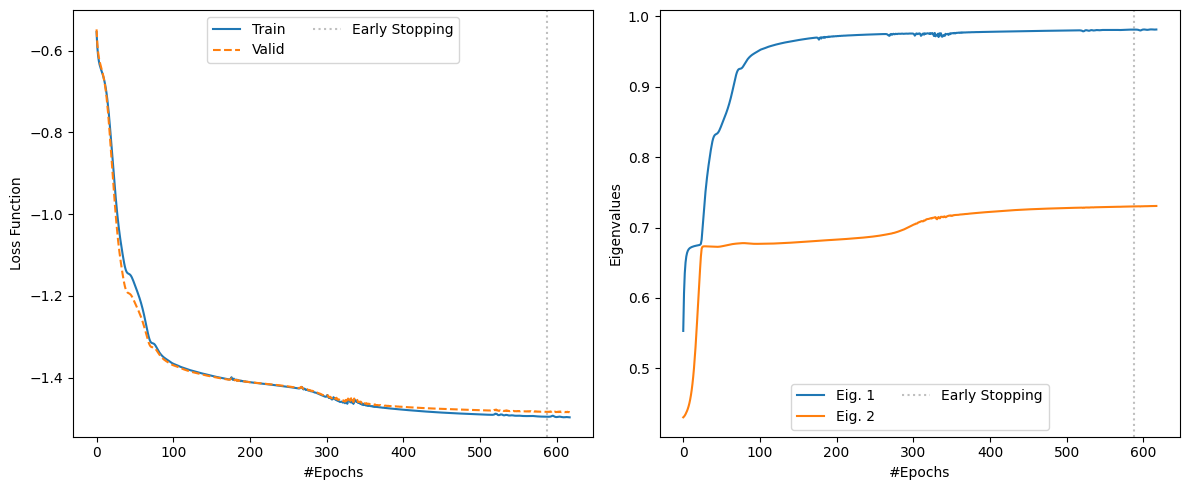

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=100)

# Loss function
ax = axs[0]
loss_train_cpu = torch.tensor(model.loss_train, device = 'cpu')
loss_valid_cpu = torch.tensor(model.loss_valid, device = 'cpu')
ax.plot(loss_train_cpu,'-',label='Train')
ax.plot(loss_valid_cpu,'--',label='Valid')
ax.set_ylabel('Loss Function')

# Eigenvalues vs epoch
ax = axs[1]
probs = [t.cpu() for t in model.evals_train]
evals_train = np.asarray(torch.cat(probs))
for i in range(n_eig):
    ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
ax.set_ylabel('Eigenvalues')

# Common setup
for ax in axs:
    if model.earlystopping_.early_stop:
        ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
        ax.set_xlabel('#Epochs')
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()

**CVs isolines in physical space**

Using device: cuda

Quadro RTX 5000 with Max-Q Design


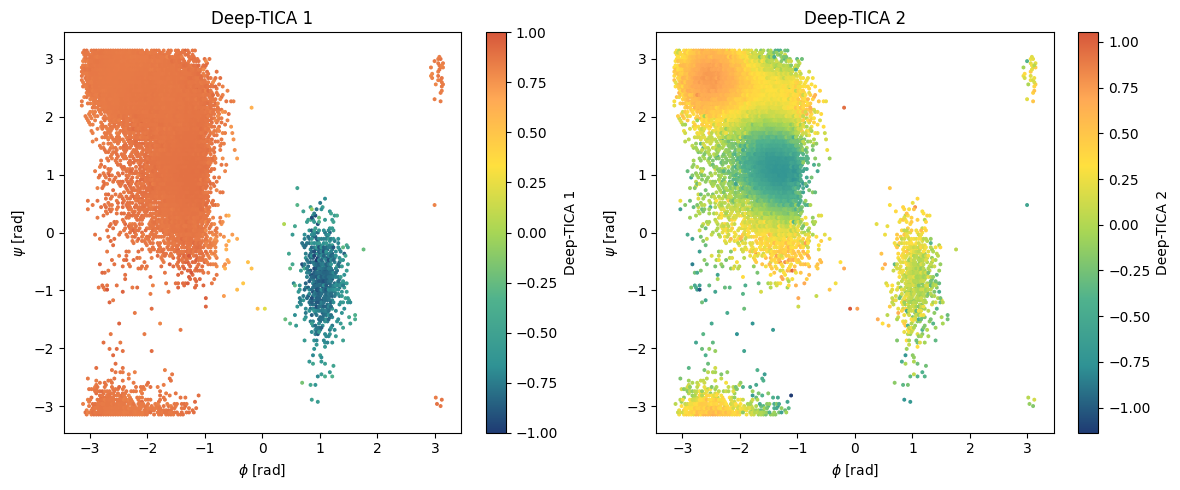

In [7]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
#Additional Info when using cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
model = model.to(device)
with torch.no_grad():
    s = model(torch.Tensor(X).to(device)).cpu().numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap=cm_fessa)
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

**Free energy profile along Deep-TICA CVs**

Note that, since in the exploratory multithermal simulation only a few recrossing between the states were observed, the free energy estimate is very noisy, especially in the transition region where almost no points were recorded.

/workspace/deep-learning-slow-modes/tutorial/../mlcvs/fes.py:81: RuntimeWarning: divide by zero encountered in log
  fes=-kbt*np.log(prob/max_prob)


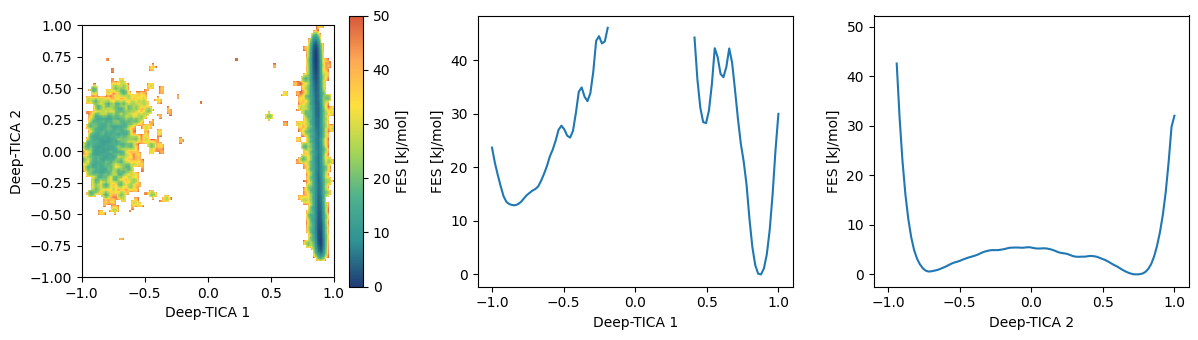

In [8]:
fig,axs = plt.subplots(1,n_eig+1,figsize=(4*(n_eig+1),3.5),dpi=100)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X).to(device)).cpu().numpy()

fes_cutoff = 50

# FES 2D
ax = axs[0]
fes = compute_fes_2d(s[:,0],s[:,1],logweights=logweight,kbt=kb*temp,sigma=0.01,extent=(-1,1,-1,1),grid_bin=100)
fes[fes>fes_cutoff] = np.nan
pp = ax.imshow(fes,vmax=fes_cutoff,cmap=cm_fessa,extent=(-1,1,-1,1),origin='lower')
cbar = plt.colorbar(pp,ax=ax)
ax.set_xlabel('Deep-TICA 1')
ax.set_ylabel('Deep-TICA 2')
cbar.set_label('FES [kJ/mol]')

# FES 1D
for i,ax in enumerate(axs[1:]):
    grid,fes = compute_fes_1d(s[:,i],logweights=logweight,kbt=kb*temp,sigma=0.02,extent=(-1,1),grid_bin=100)
    fes[fes>fes_cutoff] = np.nan
    ax.plot(grid,fes)
    ax.set_xlabel('Deep-TICA '+str(i+1))
    ax.set_ylabel('FES [kJ/mol]')
    
plt.tight_layout()
plt.show()

## 6. Export

In order to use the trained Deep-TICA CVs for enhanced sampling we export the model using torchscript, which allow to load the model in PLUMED via the C++ torch library (libtorch). Please see the tutorial about the [DeepLDA CVs](https://colab.research.google.com/github/luigibonati/data-driven-CVs/blob/master/code/Tutorial%20-%20DeepLDA%20training.ipynb#scrollTo=F7qSDdBGn8Vv) for instructions about how to configure PLUMED and install the PLUMED-torch interface.

In [12]:
# specify folder name and create folder
import os
cwd = os.getcwd()
save_folder = cwd + "/deeptica/"
!mkdir -p {save_folder}
# export checkpoint (for loading the model back to python) and torchscript traced module
model.export(save_folder)

@@ checkpoint:  /workspace/deep-learning-slow-modes/tutorial/deeptica/torch_checkpoint.pt
Using device: cuda

Quadro RTX 5000 with Max-Q Design
@@ traced torchscript model (for C++) in:  /workspace/deep-learning-slow-modes/tutorial/deeptica/model_deeptica.pt
